In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

    def use_checkpointing(self):
        self.inc = torch.utils.checkpoint(self.inc)
        self.down1 = torch.utils.checkpoint(self.down1)
        self.down2 = torch.utils.checkpoint(self.down2)
        self.down3 = torch.utils.checkpoint(self.down3)
        self.down4 = torch.utils.checkpoint(self.down4)
        self.up1 = torch.utils.checkpoint(self.up1)
        self.up2 = torch.utils.checkpoint(self.up2)
        self.up3 = torch.utils.checkpoint(self.up3)
        self.up4 = torch.utils.checkpoint(self.up4)
        self.outc = torch.utils.checkpoint(self.outc)

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print("Using device:", device)

class down(nn.Module):
    def __init__(self, din, dout):
        super().__init__()
        self.down = nn.Sequential(
            nn.Conv2d(din, dout, kernel_size=3, padding=1),
            nn.BatchNorm2d(dout),
            nn.ReLU(),
            nn.Conv2d(dout, dout, kernel_size=3, padding=1),
            nn.BatchNorm2d(dout),
            nn.ReLU(),
        )
    
    def forward(self, x):
        return self.down(x)
    
class up(nn.Module):
    def __init__(self, din, dout):
        super().__init__()
        self.up = nn.Sequential(
            nn.Conv2d(din, dout, kernel_size=3, padding=1),
            nn.BatchNorm2d(dout),
            nn.ReLU(),
            nn.Conv2d(dout, dout, kernel_size=3, padding=1),
            nn.BatchNorm2d(dout),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.up(x)

class unet(nn.Module):
    def __init__(self):
        super().__init__()
        self.scale = 1 # maybe using the original channels might be better
        self.flatten = nn.Flatten()
        self.down1 = down(3, self.scale * 64)
        self.down2 = down(self.scale * 64, self.scale * 128)
        self.down3 = down(self.scale * 128, self.scale * 256)
        self.down4 = down(self.scale * 256, self.scale * 512)
        self.down5 = down(self.scale * 512, self.scale * 1024)
        self.up1 = up(self.scale * 1024, self.scale * 512)
        self.up2 = up(self.scale * 512, self.scale * 256)
        self.up3 = up(self.scale * 256, self.scale * 128)
        self.up4 = up(self.scale * 128, self.scale * 64)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.upsample = nn.Upsample(scale_factor=2)
        self.upconv1 = nn.Conv2d(self.scale * 1024, self.scale * 512, kernel_size=3, padding=1)
        self.upconv2 = nn.Conv2d(self.scale * 512, self.scale * 256, kernel_size=3, padding=1)
        self.upconv3 = nn.Conv2d(self.scale * 256, self.scale * 128, kernel_size=3, padding=1)
        self.upconv4 = nn.Conv2d(self.scale * 128, self.scale * 64, kernel_size=3, padding=1)
        self.output = nn.Sequential(
            nn.Conv2d(self.scale * 64, 4, kernel_size=1),
            # nn.Softmax(dim=1)
        )

    def forward(self, x):
        x1 = self.down1(x)
        x2 = self.down2(self.maxpool(x1))
        x3 = self.down3(self.maxpool(x2))
        x4 = self.down4(self.maxpool(x3))
        x5 = self.down5(self.maxpool(x4))
        x = self.up1(torch.cat([x4, self.upconv1(self.upsample(x5))], dim=1))
        x = self.up2(torch.cat([x3, self.upconv2(self.upsample(x))], dim=1))
        x = self.up3(torch.cat([x2, self.upconv3(self.upsample(x))], dim=1))
        x = self.up4(torch.cat([x1, self.upconv4(self.upsample(x))], dim=1))
        pre_output = self.output(x)
        return pre_output



Using device: cuda


In [198]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, PILToTensor
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


import os
from torchvision.io import decode_image

target_batch_size = 64
batch_size = 2

class dataset(Dataset):
    def __init__(self, img_dir, label_dir, transform=None, target_transform=None):
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.img_names = sorted([os.path.splitext(filename)[0] for filename in os.listdir(img_dir)])
        self.len = len(self.img_names)
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return self.len
    
    def __getitem__(self, idx):
        img = decode_image(os.path.join(self.img_dir, self.img_names[idx] + ".jpg")).float()/255
        label = decode_image(os.path.join(self.label_dir, self.img_names[idx] + ".png"))

        if self.transform:
            img = self.transform(img)

        if self.target_transform:
            label = self.target_transform(label)

        return img, label
    
def display_img_label(data, idx):
    img, label = data[idx]
    figure = plt.figure(figsize=(10,20))
    figure.add_subplot(1, 2, 1)
    plt.imshow(img.permute(1, 2, 0))

    figure.add_subplot(1, 2, 2)
    plt.imshow(label.permute(1, 2, 0), cmap='grey')

    plt.show()

class target_remap(object):
    def __call__(self, img):
        img[img == 255] = 3
        return img

def diff_size_collate(batch):
    imgs = [item[0] for item in batch]
    labels = [item[1] for item in batch]
    return imgs, labels



training_data = dataset("rtrain/color", "rtrain/label", target_transform=target_remap())
test_data = dataset("Test/color", "Test/label", target_transform=target_remap())

train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True, pin_memory=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True, pin_memory=True, collate_fn=diff_size_collate)

In [ ]:
from tqdm import tqdm
import numpy as np
use_amp = True

def train_loop(dataloader, model, loss_fn, optimizer, scaler):
    size = len(dataloader.dataset)

    to_print=True
    losses = []
    model.train()
    for batch, (X, y) in enumerate(tqdm(dataloader, total=len(dataloader), desc="Training")):
    # for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        with torch.autocast(device_type='cuda', dtype=torch.float16, enabled=use_amp):
            pred = model(X)
            loss = loss_fn(pred, y.squeeze(1).long())
        # print(f"batch {batch} occupying: {torch.mps.current_allocated_memory()}", flush=True)
        scaler.scale(loss).backward()

        if batch % (target_batch_size//batch_size) == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            
            losses.append(loss.item())
            if to_print:
                print(f"batch {batch} occupying: {torch.cuda.device_memory_used()}", flush=True)
                to_print = False

def test_loop(dataloader, model, loss_fn):
    # size = len(dataloader.dataset)
    model.eval()

    num_batches = len(dataloader)
    loss = 0

    with torch.no_grad():
        for X, y in tqdm(dataloader, total=len(dataloader), desc="Test"):
            X, y = X.to(device), y.to(device)

            with torch.autocast(device_type='cuda', dtype=torch.float16, enabled=use_amp):
                pred = model(X)
                loss += loss_fn(pred, y.squeeze(1).long()).item()

    loss /= num_batches
    print(f"Test Error: \nAvg loss: {loss:>8f} \n")
    return loss

model = unet().to(device)
# model = UNet(3,4).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
scaler = torch.amp.GradScaler("cuda" ,enabled=use_amp)

model_path = "unet"

epochs = 100
dev_loss = np.inf
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer, scaler)
    new_dev_loss = test_loop(test_dataloader, model, loss_fn)
    
    if new_dev_loss <= dev_loss:
        dev_loss = new_dev_loss
        checkpoint = {"model": model.state_dict(),
              "optimizer": optimizer.state_dict(),
              "scaler": scaler.state_dict()}
        torch.save(checkpoint, f"unet/checkpoint")
        
print("Done!")


In [5]:
# import gc

# model.cpu()
# del model
# torch.cuda.empty_cache()
# gc.collect()

In [6]:
dev_loss

0.2578259012077278

In [12]:

checkpoint = torch.load("unet/checkpoint")

model.load_state_dict(checkpoint["model"])
# optimizer.load_state_dict(checkpoint["optimizer"])
# scaler.load_state_dict(checkpoint["scaler"])

model.to(device)
model.eval()
X, y = next(iter(test_dataloader))

X = X.to(device)
with torch.no_grad():
  with torch.autocast(device_type='cuda', dtype=torch.float16, enabled=use_amp):    
    res = model(X)

In [14]:
res.size()

torch.Size([8, 4, 512, 512])

In [23]:
torch.argmax(res[0], dim=0)

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0')

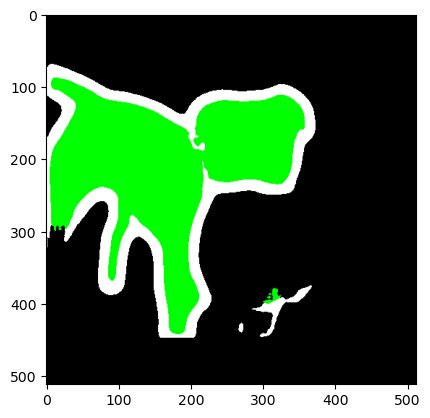

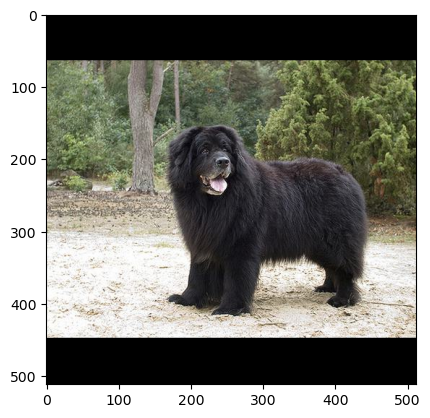

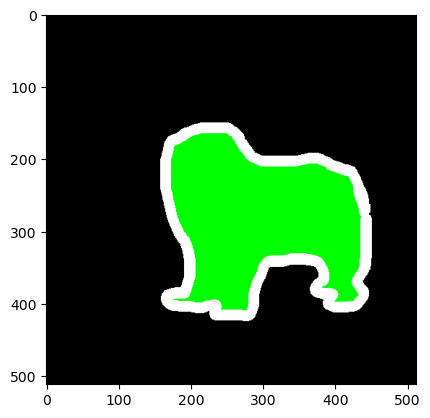

In [125]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torchvision.transforms.functional

def plot_tensor_with_custom_colors(tensor, color_map):
    """
    Plots a tensor with custom colors using matplotlib.

    Args:
        tensor (torch.Tensor): A 2D or 3D tensor with integer values representing different categories.
                                The values should correspond to keys in the color_map.
        color_map (dict): A dictionary mapping integer values to RGB color tuples (e.g., (0, 0, 0) for black).
    """

    # Convert to numpy if it's a tensor
    if isinstance(tensor, torch.Tensor):
        tensor = tensor.cpu().numpy()

    # Ensure the tensor is 2D or 3D
    if len(tensor.shape) not in [2, 3]:
        raise ValueError("Tensor must be 2D or 3D")

    # Create an RGB image from the color map
    height, width = tensor.shape[:2]  # Handle both 2D and 3D tensors
    rgb_image = np.zeros((height, width, 3), dtype=np.uint8)

    for value, color in color_map.items():
        mask = (tensor == value)
        rgb_image[mask] = color

    # Display the image using matplotlib
    plt.imshow(rgb_image)
    plt.show()


idx=1
# Create a dummy tensor
image_tensor = torch.argmax(res[idx], dim=0)  # Values 0, 1, 2, 3

# Define the color map
color_map = {
    0: (0, 0, 0),      # Black
    1: (255, 0, 0),    # Red
    2: (0, 255, 0),    # Green
    3: (255, 255, 255),  # White
    255: (255,255,255)
}



# Plot the tensor with custom colors
plot_tensor_with_custom_colors(image_tensor, color_map)
img_np = X[idx].permute(1,2,0).cpu().numpy()

plt.imshow(img_np)
plt.show()
plot_tensor_with_custom_colors(y[idx].squeeze(), color_map)

In [73]:
image_tensor.size()

torch.Size([512, 512])

In [ ]:
import torch
import torch.nn.functional as F
from torchvision.transforms import functional as TF
from tqdm import tqdm

# Assume these are defined somewhere in your code
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
use_amp = True  # or False depending on your setup

def resize_with_padding(image, target_size=512):
    """
    Resize a single image (Tensor of shape (C, H, W)) so that the longer side
    equals target_size, preserving aspect ratio; add black padding as needed.
    Returns the resized and padded image, plus a metadata dictionary.
    """
    _, orig_h, orig_w = image.shape
    scale = min(target_size / orig_w, target_size / orig_h)
    new_w = int(round(orig_w * scale))
    new_h = int(round(orig_h * scale))
    
    # Resize the image
    image_resized = TF.resize(image, size=(new_h, new_w))
    
    # Compute padding on each side
    pad_w = target_size - new_w
    pad_h = target_size - new_h
    pad_left = pad_w // 2
    pad_right = pad_w - pad_left
    pad_top = pad_h // 2
    pad_bottom = pad_h - pad_top

    # Pad the image (padding order: left, top, right, bottom)
    image_padded = TF.pad(image_resized, padding=(pad_left, pad_top, pad_right, pad_bottom), fill=0)

    meta = {
        "original_size": (orig_h, orig_w),
        "new_size": (new_h, new_w),
        "pad": (pad_left, pad_top, pad_right, pad_bottom),
        "scale": scale
    }
    return image_padded, meta

def reverse_resize_and_padding(image, meta, interpolation="bilinear"):
    """
    Remove the padding from image (Tensor of shape (C, target_size, target_size))
    using metadata and then resize the cropped image back to the original size.
    interpolation: "bilinear" for continuous outputs; use "nearest" for label maps.
    """
    pad_left, pad_top, pad_right, pad_bottom = meta["pad"]
    new_h, new_w = meta["new_size"]
    
    # Crop out the padding: from pad_top to pad_top+new_h and pad_left to pad_left+new_w.
    image_cropped = image[..., pad_top: pad_top + new_h, pad_left: pad_left + new_w]
    
    # Resize the cropped image back to the original size.
    orig_h, orig_w = meta["original_size"]
    # F.interpolate expects a 4D tensor.
    image_original = F.interpolate(image_cropped.unsqueeze(0),
                                   size=(orig_h, orig_w),
                                   mode=interpolation,
                                   align_corners=False if interpolation != "nearest" else None)
    return image_original.squeeze(0)

def process_batch_forward(batch_images, target_size=512):
    """
    Process a batch (Tensor of shape (N, C, H, W)) by resizing each image to target_size
    with aspect ratio preserved (adding black padding).
    Returns the processed batch and a list of meta dictionaries.
    """
    resized_batch = []
    meta_list = []
    for image in batch_images:
        image_resized, meta = resize_with_padding(image, target_size)
        resized_batch.append(image_resized)
        meta_list.append(meta)
    return torch.stack(resized_batch), meta_list

def process_batch_reverse(batch_outputs, meta_list, interpolation="bilinear"):
    """
    Given a batch of network outputs of shape (N, C, target_size, target_size) and the
    corresponding meta info, reverse the transform for each one to obtain predictions at their
    original sizes.
    """
    original_outputs = []
    for output, meta in zip(batch_outputs, meta_list):
        restored = reverse_resize_and_padding(output, meta, interpolation=interpolation)
        original_outputs.append(restored)
    return original_outputs


def eval_loop(dataloader, model, loss_fn, target_size=512, interpolation="nearest"):
    """
    Evaluation loop that preprocesses input images (resizing with padded black margins)
    before passing them to the model, then inversely transforms the network outputs to the
    original sizes (cropping out the paddings) before computing the loss.
    
    Args:
       dataloader: yields batches of (input images, ground-truth labels)
       model: the neural network model
       loss_fn: the loss function which compares the model output to labels
       target_size: the size to which each image will be resized (default: 512)
       interpolation: interpolation mode for the reverse transform; use "nearest" for segmentation labels.
    """
    model.eval()
    num_batches = len(dataloader)
    total_loss = 0.0

    with torch.no_grad():
        for X, y in tqdm(dataloader, total=num_batches, desc="Eval"):

            # X, y are lists and cannot be transfered to gpu
            # plt.imshow(X[0].permute(1,2,0).numpy())
            # plt.show()

            # Forward transform: resize each image in the batch (and record metadata).
            X, meta_list = process_batch_forward(X, target_size=target_size)
            X = X.to(device)

            # plt.imshow(X[0].permute(1,2,0).cpu().numpy())
            # plt.show()

            with torch.autocast(device_type='cuda', dtype=torch.float16, enabled=use_amp):
                # Network prediction on the transformed (512x512) images.
                pred = model(X)
            
            # tmp_pred = torch.argmax(pred[0], dim=0)
            # plot_tensor_with_custom_colors(tmp_pred, color_map)
            
            # print(pred[0])
            # Reverse transform: recover the original sizes (cropping the padding then resizing).
            pred = process_batch_reverse(pred, meta_list, interpolation=interpolation)
            # plot_tensor_with_custom_colors(torch.argmax(pred[0], dim=0), color_map)
            
            
            
            # plot_tensor_with_custom_colors(y[0].squeeze(0), color_map)

            # Compute loss between the restored prediction and the original label.
            for p, label in zip(pred, y):
                # plot_tensor_with_custom_colors(torch.argmax(p, dim=0), color_map)
            
                # plot_tensor_with_custom_colors(label.squeeze(0), color_map)
                
                # Move individual prediction and label to the device
                p = p.to(device).unsqueeze(0)  # Add batch dimension
                label = label.to(device).long().unsqueeze(0)  # Add batch dimension and ensure type is long
                
                print(p.size())
                print(label.size())
                # Calculate the loss for the current pair
                loss = loss_fn(p, label.squeeze(1))
                total_loss += loss.item()
                
            print(total_loss)
            return
    avg_loss = total_loss / num_batches
    print(f"Test Error: \nAvg loss: {avg_loss:>8f} \n")



In [232]:
loss_fn = nn.CrossEntropyLoss()
eval_loop(test_dataloader, model, loss_fn)

Eval:   0%|          | 0/1847 [00:00<?, ?it/s]

torch.Size([1, 1, 334, 500])
torch.Size([1, 1, 334, 500])
torch.Size([1, 1, 375, 500])
torch.Size([1, 1, 375, 500])
nan


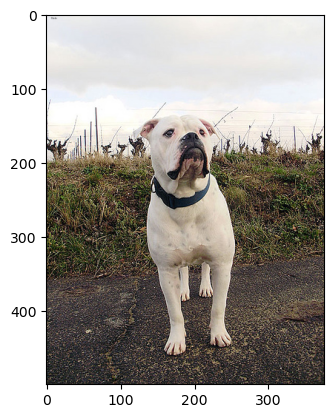

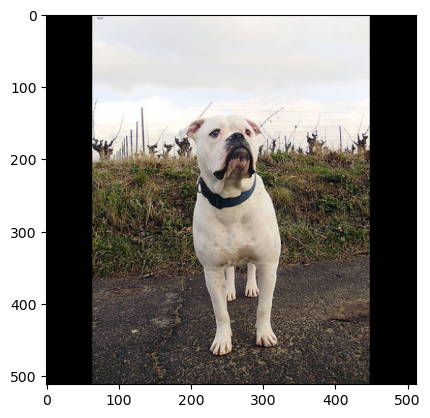

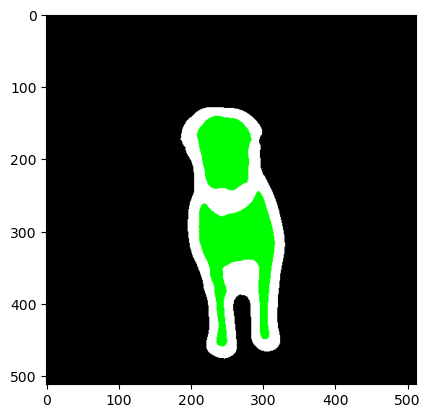

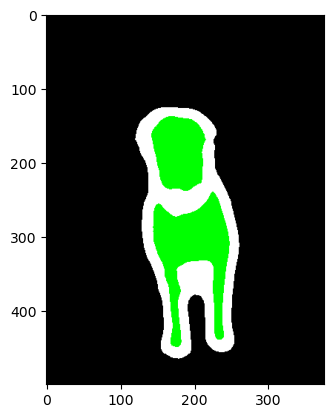

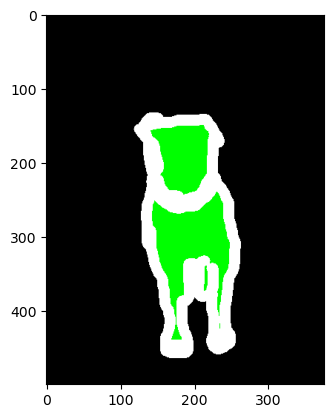

In [126]:
img = decode_image("Test/color/american_bulldog_5.jpg").float()/255
plt.imshow(img.permute(1,2,0).numpy())
plt.show()

img, meta = resize_with_padding(img)
plt.imshow(img.permute(1,2,0).numpy())
plt.show()

img = img.to(device)
pred = model(img.unsqueeze(0))
rpred = reverse_resize_and_padding(pred.squeeze(0), meta, interpolation="nearest")
pred = torch.argmax(pred[0], dim=0)
rpred = torch.argmax(rpred, dim=0)
plot_tensor_with_custom_colors(pred, color_map)
plot_tensor_with_custom_colors(rpred, color_map)

label = decode_image("Test/label/american_bulldog_5.png")
plot_tensor_with_custom_colors(label.squeeze(0), color_map)
# print(label.size())
# plt.imshow(label.permute(1,2,0).numpy())
# plt.show()